<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Kaggle-Challenge/blob/master/NB_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [3]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [4]:
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

**Baseline accuracy will be 52.7% that shot was not made.**

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df.dtypes

In [0]:
df['secs_remaining_in_period'] = df['minutes_remaining']*60 + df['seconds_remaining']

In [0]:
df['seconds_remaining_in_game'] = ((4 - df['period']) * 12 * 60) + df['secs_remaining_in_period']

In [0]:
df.loc[df.htm == 'GSW', 'homecourt_adv'] = 1
df.loc[df.htm != 'GSW', 'homecourt_adv'] = 0

In [85]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,secs_remaining_in_period,seconds_remaining_in_game,homecourt_adv
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,685,2845,1.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,571,2731,1.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,362,2522,1.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,589,2029,1.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,139,1579,1.0


In [0]:
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2018-10-01')
train = df[df.game_date < cutoff]
test  = df[df.game_date >= cutoff]


In [0]:
df['vtm'].value_counts()

In [0]:
df.groupby('vtm')['shot_made_flag'].sum()


In [54]:
train.shape, test.shape

((12249, 21), (1709, 21))

In [0]:
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report


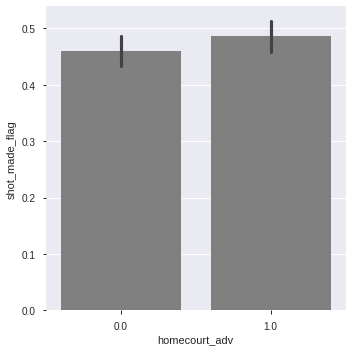

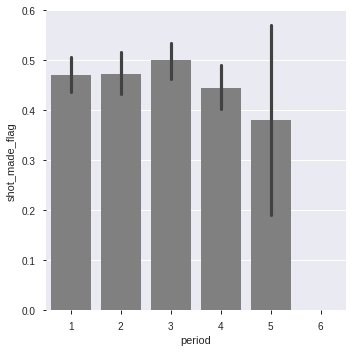

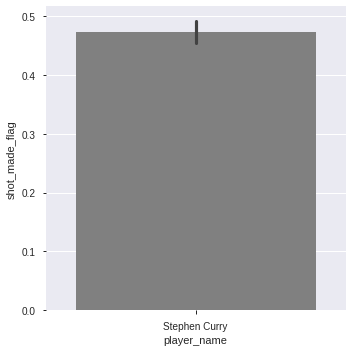

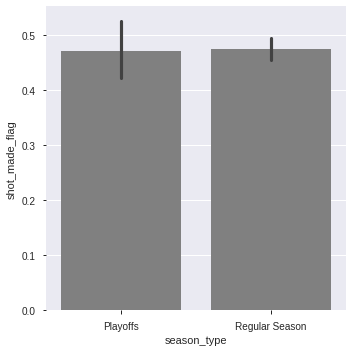

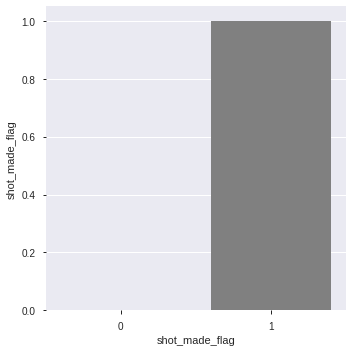

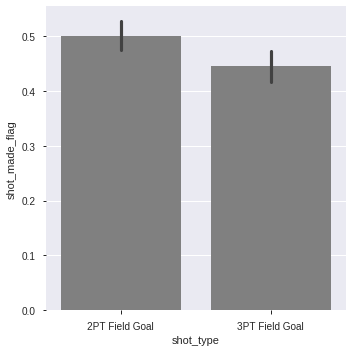

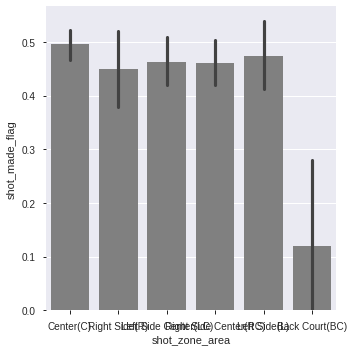

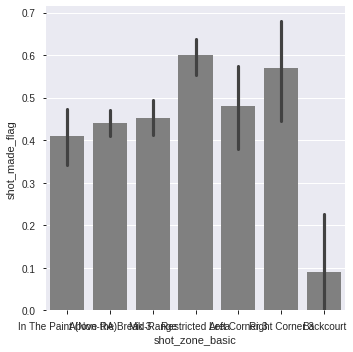

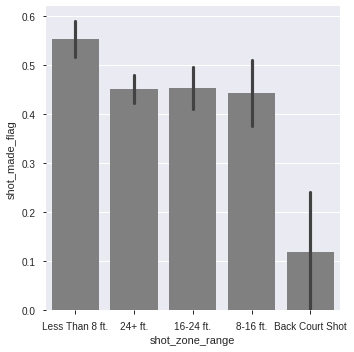

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='shot_made_flag', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

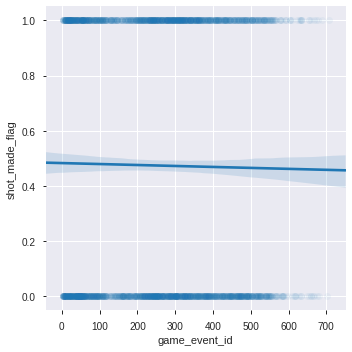

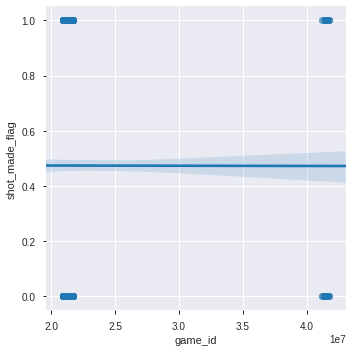

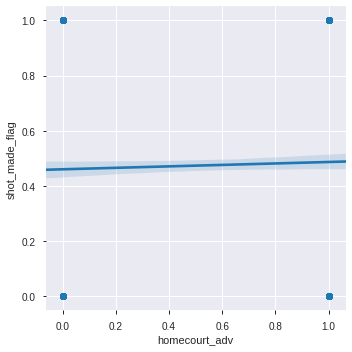

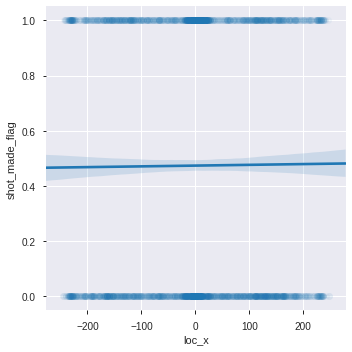

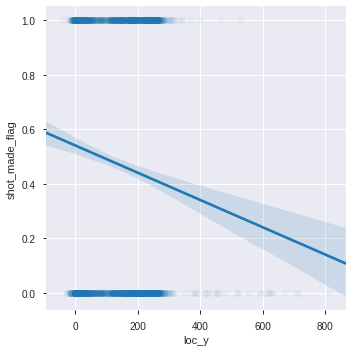

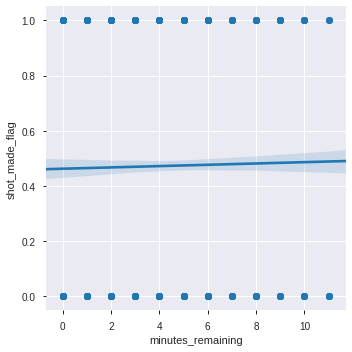

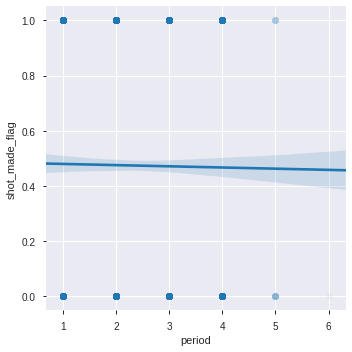

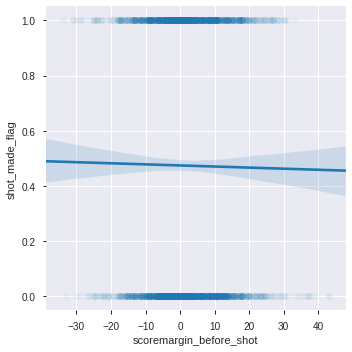

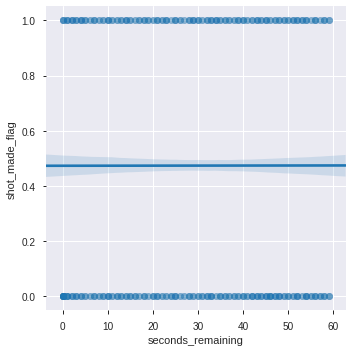

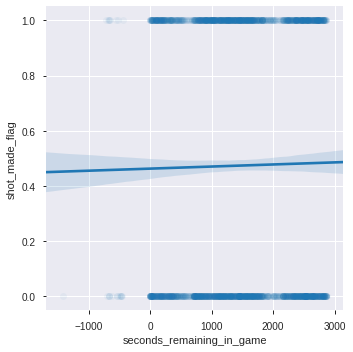

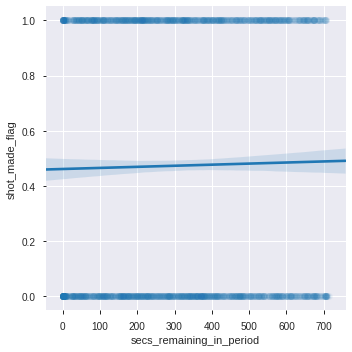

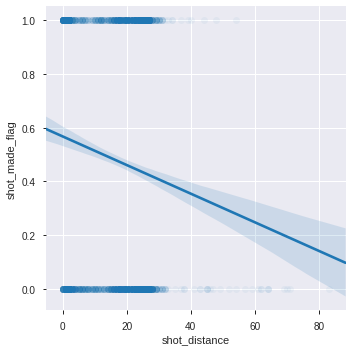

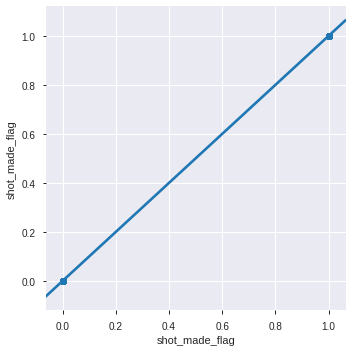

In [182]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='shot_made_flag', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [11]:
train['player_name'].value_counts()

Stephen Curry    12249
Name: player_name, dtype: int64

In [160]:
# The status_group column is the target
target = 'shot_made_flag'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'player_name', 'game_date'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 100].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features 

print(features)


['game_id', 'game_event_id', 'period', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'loc_x', 'loc_y', 'scoremargin_before_shot', 'secs_remaining_in_period', 'seconds_remaining_in_game', 'homecourt_adv', 'action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type']


In [0]:
df.dtypes

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['shot_made_flag'], random_state=42)

In [18]:
train.shape, val.shape, test.shape

((9799, 20), (2450, 20), (1709, 20))

In [0]:
X_train = train[features] 
y_train = train[target] 
X_val = val[features] 
y_val = val[target] 
X_test = test[features]


## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
#Trying Decision Tree

from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)



In [0]:
#Trying Random Forest


import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)


In [0]:
#Trying Random Forest with Target Encoder


import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [145]:
# Score on val
print('Validation Accuracy of Decision Tree', pipeline.score(X_val, y_val))


Validation Accuracy of Decision Tree 0.5832669322709163


In [170]:
print('Validation Accuracy of Random Forest', pipeline.score(X_val, y_val))

Validation Accuracy of Random Forest 0.6510903426791277


## 7. Get your model's test accuracy

> (One time, at the end.)

In [165]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)
y_test = test[target]
print('Test Accuracy of Random Forest', accuracy_score(y_test, y_pred))

Test Accuracy of Random Forest 0.6184903452311293


In [174]:
#Randomized Search for Parameter optimization of Random Forest Classifier

from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {    
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(200, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [175]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.8315907787665398, 'randomforestclassifier__n_estimators': 204, 'simpleimputer__strategy': 'median'}
Cross-validation MAE 0.33229450720685627


In [176]:
pipeline = search.best_estimator_

y_pred = pipeline.predict(X_test)
y_test = test[target]
print('Test Accuracy of Random Forest', accuracy_score(y_test, y_pred))


Test Accuracy of Random Forest 0.6214160327677004


In [178]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

print('X_train shape after encoding', encoded.shape)

X_train shape before encoding (2567, 20)
X_train shape after encoding (2567, 138)


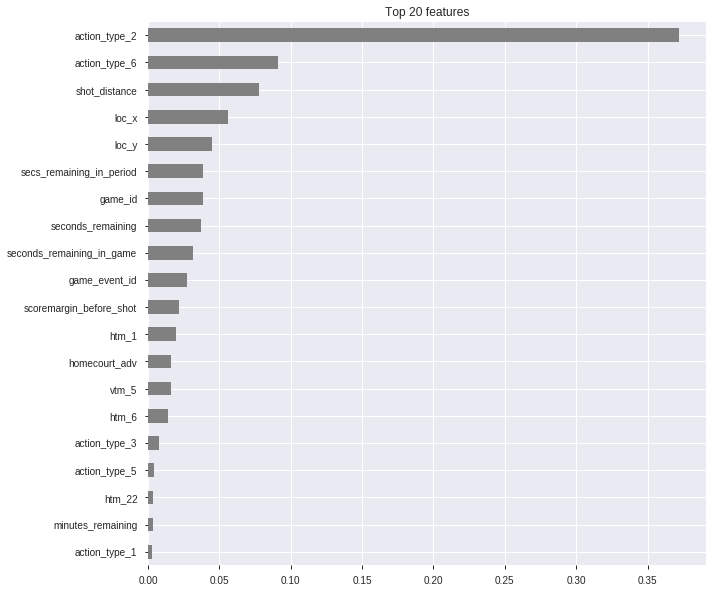

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [137]:
correct_predictions = 85+36 
total_predictions = 85+36+58+8
print('Accuracy is: ', correct_predictions/total_predictions)

Accuracy is:  0.6470588235294118


### Calculate precision

In [138]:
true_positives = 36
false_positives = 58
print('Precision is :', true_positives/(true_positives + false_positives))


Precision is : 0.3829787234042553


### Calculate recall

In [140]:
true_positives = 36
false_negatives = 8
print('Recall is :', true_positives/(true_positives + false_negatives))

Recall is : 0.8181818181818182
